In [1]:
import pandas as pd

import numpy as np
from itertools import combinations
from sklearn.ensemble import RandomForestRegressor
from IPython.display import clear_output

from matplotlib import pyplot as plt

import pickle

from scipy.stats import pearsonr


volume = 'Data'
volume = 'My Passport for Mac'

In [2]:
import numpy as np
height_width_ratio = 2. / (1 + np.sqrt(5))
(height_width_ratio+1)*height_width_ratio

0.9999999999999999

In [3]:
def summarize_result(rf,X,y, year,smoothing=1,plot_display=False):
    ypred = np.round(rf.predict(X))
    ypred2 = np.round(rf.oob_prediction_)
    residu = ypred2 - y
    if plot_display:
        fig,axes = plt.subplots(1,1,figsize=(10,3))
        ymax = np.ceil((np.abs(residu).max()+1)/10)*10
        ymin = -ymax
        axes.plot(year, residu ,marker='.', ls='none',color='k',markersize=2,alpha = 0.5)
        axes.set_ylim(ymin,ymax)
        axes.axhline(0, lw=0.5, color='k')

        df_residu = pd.DataFrame({'residual':residu, 'year':year}).groupby('year').mean().residual
        if smoothing != 1:
            ax2 = axes.twinx()
            ax2.set_ylabel('Mean residual (days)')
            ax2.set_ylim(ymin/smoothing, ymax/smoothing)
        else:
            ax2 = axes
        axes.set_ylabel('Residual (days)')
        axes.set_xlabel('Year')

        df_residu.rolling(smoothing).mean().plot(lw=3,ax=ax2,color='C0')
        plt.show()
    
    ame, rmse = np.abs(ypred2 - y).mean(), np.sqrt(((ypred2-y)**2).sum()/len(ypred2))
    print(f'AME: {ame:.2f}, RMSE: {rmse:.2f}, OOB score: {rf.oob_score_:.3f}')
    return ame, rmse, rf.oob_score_
    

def fit_predict(df, features, ycolumn, unique_columns =['Depth_avg','Lake_area'],plot_display=False):
    
    df_train = df.copy()
    
    X = df_train.loc[:,features]
    y = df_train.loc[:, ycolumn]
    year = df_train.loc[:,'start_year']
    ind = ~y.isnull() & ~X.isnull().any(axis=1)

    y = y[ind]
    X = X[ind]
    year = year[ind]
    rf = RandomForestRegressor(random_state=31,max_depth=None,oob_score=True)

    rf.fit(X,y)
    
    n_obs = len(y)
    
    df_fi = pd.DataFrame(rf.feature_importances_,index=X.columns)
    
    ame, rmse, oob = summarize_result(rf,X,y, year,plot_display=plot_display)

    return ame, rmse, oob, df_fi, n_obs

In [4]:
version = 'v11'
version = 'v11b'

if version[:3]=='v11':
    lakecodelabel = 'lakecode'
    mergedversion = f'_{version}'
    suffix = f'_{version}'
else:
    lakecodelabel = 'level_0'
    mergedversion = ''
    suffix = '_v10b'

df_data0 = pd.read_csv(f'/Volumes/{volume}/IceModels/merged_model_input{mergedversion}.csv')

#suffix = '_v10' # to match model_input_v10

#suffix = '_v10b' # for output of no-slope_100 model

df2 = pd.read_csv(f'/Volumes/{volume}/IceModels/model_input_{version}.csv',low_memory=False)


lakecode_dict = df2[[lakecodelabel,'lake']].drop_duplicates().set_index(lakecodelabel)['lake'].to_dict()
df2 = None

In [5]:
less_than_zero_days = np.arange(-183,183)[(df_data0.loc[:,'-183':'182']<0).any(axis=0)]
earliest = less_than_zero_days.min()
latest = less_than_zero_days.max()
#cc = df_data0.loc[:,-183:182].loc[:,(df_data0.loc[:,-183:182]<0).any(axis=0)].columns
#earliest = cc[0]
#latest = int(np.max([cc[-1], df_data0.ice_off_doy.max()]))
print(f'Earliest below zero: {earliest}; Latest below zero: {latest}')

# earliest and latest ice on and ice off
earliest2 = df_data0.ice_on_doy.min()
latest2 = df_data0.ice_off_doy.max()
print(f'Earliest ice on: {earliest2}; Latest ice off: {latest2}')

earliest = int(np.min([earliest, earliest2]))
latest = int(np.max([latest, latest2]))
print(earliest, latest)

Earliest below zero: -100; Latest below zero: 137
Earliest ice on: -80.0; Latest ice off: 145.0
-100 145


In [54]:
#df_data0
mergedversion
df2

,Unnamed: 0,lakecode,lake,start_year,ice_on_doy,ice_off_doy,ice_duration,lat,lon,TMINMAX_lagJJA,TMINMAX_lagSON,TMINMAX_DJF,TMINMAX_MAM,SNOW_lagJJA,SNOW_lagSON,SNOW_DJF,SNOW_MAM,SNWD_lagJJA,SNWD_lagSON,SNWD_DJF,SNWD_MAM,PRCP_lagJJA,PRCP_lagSON,PRCP_DJF,PRCP_MAM,...,Shore_len,Shore_dev,Vol_total,Vol_res,Vol_src,Depth_avg,Dis_avg,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat,Season,Tave_lagJJA,Rad_lagJJA,PPT_lagSON,Tave_lagSON,Rad_lagSON,PPT_DJF,Tave_DJF,Rad_DJF,PPT_MAM,Tave_MAM,Rad_MAM
0,0,DMR1,mendota,1852.0,NaN,95.0,NaN,43.12800,-89.42000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.20,2.16,197.4,197.4,2.0,4.8,6.047,377.8,258.0,2.61,640.1,-89.377833,43.086984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,DMR1,mendota,1853.0,-4.0,NaN,NaN,43.12800,-89.42000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.20,2.16,197.4,197.4,2.0,4.8,6.047,377.8,258.0,2.61,640.1,-89.377833,43.086984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,DMR1,mendota,1854.0,NaN,NaN,NaN,43.12800,-89.42000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.20,2.16,197.4,197.4,2.0,4.8,6.047,377.8,258.0,2.61,640.1,-89.377833,43.086984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,DMR1,mendota,1855.0,-13.0,105.0,118.0,43.12800,-89.42000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.20,2.16,197.4,197.4,2.0,4.8,6.047,377.8,258.0,2.61,640.1,-89.377833,43.086984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,DMR1,mendota,1856.0,-25.0,126.0,151.0,43.12800,-89.42000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.20,2.16,197.4,197.4,2.0,4.8,6.047,377.8,258.0,2.61,640.1,-89.377833,43.086984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7999,7999,xKB1987,wirth,2012.0,NaN,117.0,NaN,44.98177,-93.32369,23.800000,9.707692,-6.786667,5.664674,0.0,21.0,884.0,819.0,0.0,0.274725,76.100000,63.717391,250.9,56.8,97.4,342.8,...,3.32,1.75,1.0,0.0,3.0,3.5,0.814,14.2,247.0,2.21,120.5,-93.320389,44.985906,2012-2013,22.666667,NaN,91.0,8.533333,NaN,84.0,-7.866667,NaN,316.0,4.100000,NaN
8000,8000,xKB1987,wirth,2013.0,NaN,NaN,NaN,44.98177,-93.32369,22.716848,9.924176,-12.300000,5.735870,0.0,28.0,1450.0,297.0,0.0,0.000000,249.111111,74.673913,273.3,124.0,109.0,295.8,...,3.32,1.75,1.0,0.0,3.0,3.5,0.814,14.2,247.0,2.21,120.5,-93.320389,44.985906,2013-2014,21.233333,NaN,196.0,8.900000,NaN,106.0,-13.566667,NaN,372.0,4.766667,NaN
8001,8001,xKB1987,wirth,2014.0,NaN,86.0,NaN,44.98177,-93.32369,21.921196,7.691209,-7.488333,8.972283,0.0,240.0,406.0,181.0,0.0,15.054945,41.444444,3.586957,420.3,90.1,39.8,168.8,...,3.32,1.75,1.0,0.0,3.0,3.5,0.814,14.2,247.0,2.21,120.5,-93.320389,44.985906,2014-2015,21.266667,NaN,163.0,7.066667,NaN,55.0,-8.400000,NaN,244.0,7.833333,NaN
8002,8002,xKB1987,wirth,2015.0,NaN,76.0,NaN,44.98177,-93.32369,21.816848,12.091209,-4.261538,10.142935,0.0,130.0,655.0,150.0,0.0,1.868132,65.384615,1.195652,373.7,299.4,94.9,191.3,...,3.32,1.75,1.0,0.0,3.0,3.5,0.814,14.2,247.0,2.21,120.5,-93.320389,44.985906,2015-2016,20.933333,NaN,354.0,11.366667,NaN,112.0,-5.300000,NaN,281.0,9.000000,NaN


### Reduce features
Reduce number of features by removing highly correlated ones.

In [7]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

pvalues = calculate_pvalues(df_data0.drop_duplicates(['Vol_total','Depth_avg']).loc[:,'Lake_area':'Slope_100'].dropna())

corr = df_data0.drop_duplicates(['Vol_total','Depth_avg']).loc[:,'Lake_area':'Slope_100'].dropna().corr()

pvalue_limit = 0.001
pvalue_limit = 0.05

corr = corr[(pvalues < pvalue_limit)].stack()
corr[(corr>0.8) & (corr!=1)]

Lake_area  Shore_len    0.811442
           Vol_total    0.889315
           Dis_avg      0.886015
Shore_len  Lake_area    0.811442
           Vol_total    0.805874
Vol_total  Lake_area    0.889315
           Shore_len    0.805874
Dis_avg    Lake_area    0.886015
dtype: float64

In [8]:
select_features = ['Lake_area','Shore_dev','Depth_avg','Res_time','Elevation','Slope_100','TMINMAX_lagSON',
       'TMINMAX_lagJJA', 'TMINMAX_DJF', 'TMINMAX_MAM']

#
select_features = ['Lake_area','Shore_dev','Depth_avg','Elevation',
                   'TMINMAX_lagSON','TMINMAX_lagJJA', 
                   'TMINMAX_DJF', 'TMINMAX_MAM',
                   'SNOW_DJF',
                   'SNWD_DJF',
                   'PRCP_lagSON','PRCP_DJF','PRCP_MAM']
# modified on Sept 1, 2022 to include radiation in spring and winter
if version=='v11b':
    select_features = ['Lake_area','Shore_dev','Depth_avg','Elevation',
                   'TMINMAX_lagSON','TMINMAX_lagJJA', 
                   'TMINMAX_DJF', 'TMINMAX_MAM',
                   'SNOW_DJF',
                   'SNWD_DJF',
                   'PRCP_lagSON','PRCP_DJF','PRCP_MAM']+['Rad_DJF','Rad_MAM']

**Added on December 2 2021** Exclude MINN6 (Gull) since discrepancy between methods for ice on between stop of 1979 and start again in 1997.

**Added on January 25 2022** Excluded xKB1341 (Peltier MN2000400) because no unique HydroLAKES match

**Added on February 10 2022** additional weather-related drivers

**Added on Sept 1 2022** solar radiation in winter and spring

### Model 1. Use all data

In [9]:
ind= ~df_data0[['ice_on_doy','Depth_avg','Lake_area']].isnull().any(axis=1) & ~df_data0.lakecode.isin(['MINN6'])
df_iceon = df_data0[ind]
print('-- ICE ON  --')
print('Number of lakes:', df_iceon.lakecode.drop_duplicates().shape[0])
print('Number of rows:', df_iceon.shape[0])

ind= ~df_data0[['ice_off_doy','Depth_avg','Lake_area']].isnull().any(axis=1)
df_iceoff = df_data0[ind]
print('\n-- ICE OFF --')
print('Number of lakes:', df_iceoff.lakecode.drop_duplicates().shape[0])
print('Number of rows:', df_iceoff.shape[0])

-- ICE ON  --
Number of lakes: 73
Number of rows: 4069

-- ICE OFF --
Number of lakes: 74
Number of rows: 4866


### Model 2. Set up equal number of years per lake.
- including only rows with temperature and HydroLAKES match

In [10]:
#df_iceon_limited

In [11]:
ind= ~df_data0[['ice_on_doy','Depth_avg','Lake_area']].isnull().any(axis=1) & ~df_data0.lakecode.isin(['MINN6'])

nyears = df_data0[ind].groupby(['lakecode']).ice_on_doy.count().min()
#df_data0[ind].drop_duplicates(['Lake_area','Depth_avg']).shape[0]

df_iceon_limited = df_data0[ind].sort_values(['lakecode','start_year'],ascending=True).groupby(['lakecode']).tail(nyears)
print('Number of years in ice on data:',nyears)
print('Number of lakes:', df_iceon_limited.lakecode.drop_duplicates().shape[0])
print('Number of rows:', df_iceon_limited.shape[0])

ind= ~df_data0[['ice_off_doy','Depth_avg','Lake_area']].isnull().any(axis=1) #& ~df_data0.lakecode.isin(['MINN6'])
nyears = df_data0[ind].groupby(['lakecode']).ice_off_doy.count().min()
#df_data0[ind].drop_duplicates(['Lake_area','Depth_avg']).shape[0]

df_iceoff_limited = df_data0[ind].sort_values(['lakecode','start_year'],ascending=True).groupby(['lakecode']).tail(nyears)

print('\nNumber of years in ice off data:', nyears)
print('Number of lakes:', df_iceoff_limited.lakecode.drop_duplicates().shape[0])
print('Number of rows:', df_iceoff_limited.shape[0])


Number of years in ice on data: 31
Number of lakes: 73
Number of rows: 2263

Number of years in ice off data: 33
Number of lakes: 74
Number of rows: 2442


#### a) Explore all combinations of inputs

In [12]:
df2 = pd.read_csv(f'/Volumes/{volume}/IceModels/model_input_{version}.csv',low_memory=False)

features = []
for r in range(1,len(select_features)+1):
#for r in range(1,9):
    #features.extend([list(np.arange(earliest, latest+1))+list(i) for i in combinations(['Lake_area',''], r)])
    #features.extend([list(i) for i in combinations(df_data0.columns[-13:],r)])
    features.extend([list(i) for i in combinations(select_features,r)])
print(len(features))

32767


In [13]:
#df_iceoff
import datetime


In [60]:
# all data
dfresult = pd.DataFrame()

features = []
for r in range(1,len(select_features)+1):
    #features.extend([list(np.arange(earliest, latest+1))+list(i) for i in combinations(['Lake_area',''], r)])
    #features.extend([list(i) for i in combinations(df_data0.columns[-13:],r)])
    features.extend([list(i) for i in combinations(select_features,r)])

cnt = 0
lenfeatures = len(features)
start_time = datetime.datetime.now()
for response in ['ice_on_doy', 'ice_off_doy']:
    for ii,f in enumerate(features):
        if response == 'ice_on_doy':
            df_data = df_iceon.copy()
        else:
            df_data = df_iceoff.copy()
        #df_data.loc[:,-183:182] = df_data.loc[:,-183:182].fillna((df_data.loc[:,-183:182].shift(axis=1) + df_data.loc[:,-183:182].shift(-1,axis=1))/2.)

        ame, rmse, oob, fi, n_obs = fit_predict(df_data, f, response, plot_display=False)
        
        result = {'response':response, 'ame':ame, 'rmse':rmse,'oob':oob, 'daily':False, 'limited':False, 'Nobs':n_obs}
        for ff in f:
            if str(ff).strip('-').isdigit():
                result['daily'] = True
            else:
                result[ff] = fi.loc[ff,0]
        dfresult = dfresult.append(pd.DataFrame(result, index=[0]), ignore_index=True)
        cnt = cnt + 1
        # don't update avgtime every loop
        if cnt % 100 == 1:
            timeelapsed = datetime.datetime.now() - start_time
            avgtime = timeelapsed / cnt
        remainingtime = avgtime * (lenfeatures*2 - cnt)
        print(f"{ii+1:4d}/{lenfeatures} {response} {str(remainingtime)} remaining", ', '.join(f), n_obs)
        clear_output(wait=True)
        
        

KeyboardInterrupt: 

In [62]:
dfresult = pd.DataFrame()

In [63]:
#features

In [64]:
# limited data


for response in ['ice_on_doy', 'ice_off_doy']:
    for ii,f in enumerate(features):
        if response == 'ice_on_doy':
            df_data = df_iceon_limited.copy()
        else:
            df_data = df_iceoff_limited.copy()
        #df_data.loc[:,-183:182] = df_data.loc[:,-183:182].fillna((df_data.loc[:,-183:182].shift(axis=1) + df_data.loc[:,-183:182].shift(-1,axis=1))/2.)

        ame, rmse, oob, fi, n_obs = fit_predict(df_data, f, response, plot_display=False)
        
        result = {'response':response, 'ame':ame, 'rmse':rmse,'oob':oob, 'daily':False, 'limited':True,'Nobs':n_obs}
        for ff in f:
            if str(ff).strip('-').isdigit():
                result['daily'] = True
            else:
                result[ff] = fi.loc[ff,0]
        dfresult = dfresult.append(pd.DataFrame(result, index=[0]), ignore_index=True)
        print(f"{ii+1:4d}/{len(features)} {response}", ', '.join(f), n_obs)
        clear_output(wait=True)

AME: 4.86, RMSE: 6.90, OOB score: 0.767
32767/32767 ice_off_doy Lake_area, Shore_dev, Depth_avg, Elevation, TMINMAX_lagSON, TMINMAX_lagJJA, TMINMAX_DJF, TMINMAX_MAM, SNOW_DJF, SNWD_DJF, PRCP_lagSON, PRCP_DJF, PRCP_MAM, Rad_DJF, Rad_MAM 1980


/Users/blagrave/.virtualenvs/icemodels/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [65]:
dfresult.to_csv(f'model_scores_minus_MINN6_xKB1341{mergedversion}.csv',index=False)

In [66]:
dfresult.sort_values('oob',ascending=False)

,response,ame,rmse,oob,daily,limited,Nobs,Lake_area,Shore_dev,Depth_avg,...,TMINMAX_lagJJA,TMINMAX_DJF,TMINMAX_MAM,SNOW_DJF,SNWD_DJF,PRCP_lagSON,PRCP_DJF,PRCP_MAM,Rad_DJF,Rad_MAM
65528,ice_off_doy,4.851010,6.830746,0.770733,False,True,1980,0.012992,0.017925,0.015066,...,0.026858,0.154886,0.538746,0.022154,0.050815,0.028374,0.019386,0.022882,0.032223,0.031960
65514,ice_off_doy,4.843434,6.847767,0.770576,False,True,1980,NaN,0.019859,0.017821,...,0.027690,0.155095,0.539413,0.023076,0.051752,0.028917,0.019621,0.023283,0.032742,0.033118
65410,ice_off_doy,4.831313,6.847251,0.770456,False,True,1980,NaN,NaN,0.022612,...,0.028642,0.155656,0.539943,0.024093,0.053047,0.029951,0.020784,0.024358,0.033733,0.035696
65060,ice_off_doy,4.830104,6.803647,0.770130,False,True,2013,0.014672,0.020257,0.017011,...,NaN,0.160953,0.538510,NaN,0.062779,0.032346,NaN,0.027572,0.032572,0.038075
65223,ice_off_doy,4.879798,6.846809,0.770043,False,True,1980,0.016735,0.021800,NaN,...,0.030362,0.158159,0.543590,0.026094,0.055180,0.030595,0.022512,0.026547,0.037452,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,ice_on_doy,13.954927,19.171805,-0.110490,False,True,2263,NaN,NaN,NaN,...,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32777,ice_off_doy,11.214227,15.731153,-0.114169,False,True,2432,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
32781,ice_off_doy,11.499280,15.040815,-0.134410,False,True,2083,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
5,ice_on_doy,14.315068,19.731550,-0.178019,False,True,2263,NaN,NaN,NaN,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
dfresult = pd.read_csv(f'model_scores_minus_MINN6_xKB1341{mergedversion}.csv')

#### b) Model selection

Ice on


In [15]:
display(dfresult[(dfresult.response=='ice_on_doy') & (dfresult.TMINMAX_MAM.isnull())].mean().sort_values())

display(dfresult[(dfresult.response=='ice_on_doy') & (dfresult.TMINMAX_MAM.isnull())].sort_values('oob',ascending=False).head(100).count().sort_values(ascending=False))

/var/folders/sd/xlwt40n56h1f5l08cxsb644r0000gn/T/ipykernel_1464/4116134129.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(dfresult[(dfresult.response=='ice_on_doy') & (dfresult.TMINMAX_MAM.isnull())].mean().sort_values())


daily                0.000000
PRCP_lagSON          0.064357
Rad_MAM              0.065545
PRCP_MAM             0.072620
SNOW_DJF             0.076426
TMINMAX_lagJJA       0.077765
Rad_DJF              0.079535
SNWD_DJF             0.093877
Shore_dev            0.118418
Elevation            0.120416
Lake_area            0.174013
Depth_avg            0.185990
PRCP_DJF             0.225501
TMINMAX_DJF          0.258994
TMINMAX_lagSON       0.386420
oob                  0.663853
limited              1.000000
ame                  7.665295
rmse                10.343284
Nobs              2005.187389
TMINMAX_MAM               NaN
dtype: float64

response          100
Nobs              100
TMINMAX_DJF       100
ame               100
Depth_avg         100
Lake_area         100
TMINMAX_lagSON    100
limited           100
daily             100
oob               100
rmse              100
Elevation          89
Shore_dev          83
SNOW_DJF           74
TMINMAX_lagJJA     73
PRCP_MAM           50
PRCP_DJF           49
Rad_DJF            39
PRCP_lagSON        37
SNWD_DJF           29
Rad_MAM            28
TMINMAX_MAM         0
dtype: int64

In [16]:
dfresult.columns

Index(['response', 'ame', 'rmse', 'oob', 'daily', 'limited', 'Nobs',
       'Lake_area', 'Shore_dev', 'Depth_avg', 'Elevation', 'TMINMAX_lagSON',
       'TMINMAX_lagJJA', 'TMINMAX_DJF', 'TMINMAX_MAM', 'SNOW_DJF', 'SNWD_DJF',
       'PRCP_lagSON', 'PRCP_DJF', 'PRCP_MAM', 'Rad_DJF', 'Rad_MAM'],
      dtype='object')

In [17]:
pd.options.display.max_columns = 50
dfresult['n_params'] = dfresult.loc[:,'Lake_area':'Rad_MAM'].count(axis=1)

display(dfresult[(dfresult.response=='ice_on_doy') & #(dfresult.n_params<7)& 
                 #dfresult.Res_time.isnull() & #dfresult.limited &
                 #dfresult.Slope_100.isnull() &
         (~dfresult.Rad_DJF.isnull() & dfresult.Rad_MAM.isnull() & dfresult.TMINMAX_MAM.isnull() & dfresult.PRCP_MAM.isnull())].sort_values('rmse',ascending=True).head(40))

ice_on_features = ['Lake_area',#'Shore_dev',
                   'Depth_avg', 'Elevation','Slope_100',
                   'TMINMAX_lagSON','TMINMAX_lagJJA','TMINMAX_DJF']
ice_on_features = ['Lake_area','Shore_dev',
                   'Depth_avg', 
                   #'Elevation','Slope_100',
                   'TMINMAX_lagSON','TMINMAX_lagJJA','TMINMAX_DJF']

# 75.9 % 6.6 days AME

# six features
ice_on_features = ['Lake_area',#'Shore_dev',
                   'Depth_avg', 
                   'Elevation',#'Slope_100',
                   'TMINMAX_lagSON','TMINMAX_lagJJA','TMINMAX_DJF']
display(dfresult[(dfresult.response=='ice_on_doy') & (~dfresult[ice_on_features].isnull()).all(axis=1)].head(5))



# seven features
# 75.3 % 6.4 days AME
ice_on_features = ['Lake_area',#'Shore_dev',
                   'Depth_avg', 
                   'Elevation',#'Slope_100',
                   'Rad_DJF',
                   'TMINMAX_lagSON','TMINMAX_lagJJA','TMINMAX_DJF']
display(dfresult[(dfresult.response=='ice_on_doy') & (~dfresult[ice_on_features].isnull()).all(axis=1)].head(5))


ice_on_features = ['Lake_area',#'Shore_dev',
                   'Depth_avg', 
                   'Elevation',#'Slope_100',
                   'TMINMAX_lagSON','TMINMAX_lagJJA','TMINMAX_DJF']



,response,ame,rmse,oob,daily,limited,Nobs,Lake_area,Shore_dev,Depth_avg,Elevation,TMINMAX_lagSON,TMINMAX_lagJJA,TMINMAX_DJF,TMINMAX_MAM,SNOW_DJF,SNWD_DJF,PRCP_lagSON,PRCP_DJF,PRCP_MAM,Rad_DJF,Rad_MAM,n_params
22841,ice_on_doy,6.321626,8.620825,0.764117,False,True,1993,0.088432,0.051484,0.123096,0.030226,0.335917,0.049967,0.148918,NaN,NaN,NaN,NaN,0.123242,NaN,0.048718,NaN,9
16442,ice_on_doy,6.400401,8.696188,0.760257,False,True,1993,0.090787,0.053756,0.125625,0.033875,0.344271,NaN,0.157489,NaN,NaN,NaN,NaN,0.134293,NaN,0.059903,NaN,8
18122,ice_on_doy,6.419468,8.733784,0.757800,False,True,1993,0.102646,NaN,0.139188,0.042740,0.336447,0.050840,0.150842,NaN,NaN,NaN,NaN,0.126858,NaN,0.050438,NaN,8
27854,ice_on_doy,6.402584,8.745468,0.761250,False,True,1935,0.084356,0.049720,0.120196,0.027890,0.348392,0.045190,0.138361,NaN,0.033423,NaN,NaN,0.110266,NaN,0.042207,NaN,10
22829,ice_on_doy,6.408269,8.768159,0.760085,False,True,1935,0.093228,0.074698,0.127828,0.032786,0.371951,0.058872,0.150954,NaN,0.044280,NaN,NaN,NaN,NaN,0.045402,NaN,9
16389,ice_on_doy,6.346173,8.769518,0.755162,False,True,1999,0.101721,0.073107,0.133093,0.035680,0.370195,0.066844,0.164892,NaN,NaN,NaN,NaN,NaN,NaN,0.054467,NaN,8
27870,ice_on_doy,6.414952,8.779538,0.755260,False,True,1993,0.088330,0.049909,0.121646,0.029107,0.330818,0.044833,0.143986,NaN,NaN,NaN,0.029587,0.118290,NaN,0.043494,NaN,10
9963,ice_on_doy,6.463232,8.780350,0.754712,False,True,1999,0.105122,0.075259,0.141475,0.048238,0.383931,NaN,0.176277,NaN,NaN,NaN,NaN,NaN,NaN,0.069698,NaN,7
27851,ice_on_doy,6.451163,8.793144,0.758689,False,True,1935,0.092408,0.073800,0.126937,0.030819,0.367014,0.053015,0.146303,NaN,0.039728,NaN,0.029096,NaN,NaN,0.040881,NaN,10
22933,ice_on_doy,6.442377,8.793173,0.759142,False,True,1935,0.085966,0.051554,0.123247,0.031903,0.355479,NaN,0.144394,NaN,0.039204,NaN,NaN,0.116308,NaN,0.051945,NaN,9


,response,ame,rmse,oob,daily,limited,Nobs,Lake_area,Shore_dev,Depth_avg,Elevation,TMINMAX_lagSON,TMINMAX_lagJJA,TMINMAX_DJF,TMINMAX_MAM,SNOW_DJF,SNWD_DJF,PRCP_lagSON,PRCP_DJF,PRCP_MAM,Rad_DJF,Rad_MAM,n_params
5658,ice_on_doy,6.610252,8.930848,0.759323,False,True,2263,0.139672,NaN,0.156135,0.062199,0.387790,0.082291,0.171912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
9948,ice_on_doy,6.569598,8.858713,0.763101,False,True,2263,0.124733,0.058613,0.139545,0.045929,0.385136,0.078411,0.167634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
11235,ice_on_doy,6.572249,8.955998,0.758204,False,True,2263,0.136226,NaN,0.154130,0.058906,0.376076,0.068911,0.158901,0.046849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
11236,ice_on_doy,6.577028,8.947125,0.762477,False,True,2194,0.132226,NaN,0.156843,0.060942,0.392938,0.068569,0.139625,NaN,0.048856,NaN,NaN,NaN,NaN,NaN,NaN,7
11237,ice_on_doy,6.629409,9.060948,0.754489,False,True,2183,0.134441,NaN,0.152628,0.061614,0.380236,0.071420,0.153443,NaN,NaN,0.046218,NaN,NaN,NaN,NaN,NaN,7


,response,ame,rmse,oob,daily,limited,Nobs,Lake_area,Shore_dev,Depth_avg,Elevation,TMINMAX_lagSON,TMINMAX_lagJJA,TMINMAX_DJF,TMINMAX_MAM,SNOW_DJF,SNWD_DJF,PRCP_lagSON,PRCP_DJF,PRCP_MAM,Rad_DJF,Rad_MAM,n_params
11241,ice_on_doy,6.434217,8.816795,0.752903,False,True,1999,0.119170,NaN,0.155117,0.052208,0.374532,0.071724,0.169281,NaN,NaN,NaN,NaN,NaN,NaN,0.057968,NaN,7
16389,ice_on_doy,6.346173,8.769518,0.755162,False,True,1999,0.101721,0.073107,0.133093,0.035680,0.370195,0.066844,0.164892,NaN,NaN,NaN,NaN,NaN,NaN,0.054467,NaN,8
18104,ice_on_doy,6.310155,8.724910,0.757996,False,True,1999,0.118413,NaN,0.152594,0.049479,0.366514,0.063082,0.160472,0.040071,NaN,NaN,NaN,NaN,NaN,0.049376,NaN,8
18110,ice_on_doy,6.501809,8.865431,0.754919,False,True,1935,0.109781,NaN,0.147424,0.048384,0.377598,0.065276,0.156994,NaN,0.045486,NaN,NaN,NaN,NaN,0.049057,NaN,8
18115,ice_on_doy,6.511628,8.917132,0.748659,False,True,1935,0.116987,NaN,0.150465,0.048950,0.364729,0.064753,0.163757,NaN,NaN,0.038698,NaN,NaN,NaN,0.051661,NaN,8


Ice off

In [18]:
display(dfresult[(dfresult.response=='ice_off_doy')].mean().sort_values(ascending=False))

display(dfresult[(dfresult.response=='ice_off_doy')].sort_values('oob',ascending=False).head(100).count().sort_values(ascending=False))

/var/folders/sd/xlwt40n56h1f5l08cxsb644r0000gn/T/ipykernel_1464/2955910633.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(dfresult[(dfresult.response=='ice_off_doy')].mean().sort_values(ascending=False))


Nobs              2106.052248
rmse                 8.116182
n_params             7.500229
ame                  5.797616
limited              1.000000
oob                  0.678859
TMINMAX_MAM          0.572624
TMINMAX_DJF          0.319657
SNWD_DJF             0.172677
Elevation            0.133909
TMINMAX_lagSON       0.127360
TMINMAX_lagJJA       0.092498
Rad_MAM              0.083465
SNOW_DJF             0.077257
Rad_DJF              0.076290
PRCP_DJF             0.073531
PRCP_lagSON          0.072906
PRCP_MAM             0.068918
Shore_dev            0.049745
Depth_avg            0.041109
Lake_area            0.037994
daily                0.000000
dtype: float64

response          100
Nobs              100
TMINMAX_MAM       100
TMINMAX_DJF       100
ame               100
Elevation         100
n_params          100
limited           100
daily             100
oob               100
rmse              100
SNWD_DJF           98
Rad_DJF            98
PRCP_lagSON        88
TMINMAX_lagJJA     84
SNOW_DJF           79
PRCP_MAM           77
Rad_MAM            73
Shore_dev          63
PRCP_DJF           58
Lake_area          53
Depth_avg          49
TMINMAX_lagSON     25
dtype: int64

In [19]:
display(dfresult[(dfresult.response=='ice_off_doy') #&
                 #dfresult.Slope_100.isnull() &
                 #dfresult.Res_time.isnull()
                 #dfresult.PRCP_MAM.isnull() & dfresult.SNOW_DJF.isnull() & 
                 #dfresult.SNWD_DJF.isnull() & dfresult.PRCP_DJF.isnull() & 
                 #dfresult.PRCP_lagSON.isnull()
                 
        ].sort_values('oob',ascending=False).head(15))
ice_off_features = ['Elevation','Slope_100',
                    'TMINMAX_lagSON','TMINMAX_lagJJA','TMINMAX_DJF','TMINMAX_MAM']
#display(dfresult[(~dfresult[ice_off_features].isnull()).all(axis=1)].head(5))


ice_off_features = ['Elevation',
                    'Shore_dev',
                    #'Slope_100',
                    'TMINMAX_lagSON','TMINMAX_lagJJA','TMINMAX_DJF','TMINMAX_MAM',
                   'SNOW_DJF','PRCP_MAM']

display(dfresult[(dfresult.response=='ice_off_doy') & (~dfresult[ice_off_features].isnull()).all(axis=1)].head(5))

ice_off_features = ['Elevation',
                    'Shore_dev',
                    #'Slope_100',
                    'TMINMAX_lagSON','TMINMAX_lagJJA','TMINMAX_DJF','TMINMAX_MAM',
                   'SNOW_DJF','PRCP_MAM', 'Rad_MAM']

display(dfresult[(dfresult.response=='ice_off_doy') & (~dfresult[ice_off_features].isnull()).all(axis=1)].head(5))




,response,ame,rmse,oob,daily,limited,Nobs,Lake_area,Shore_dev,Depth_avg,Elevation,TMINMAX_lagSON,TMINMAX_lagJJA,TMINMAX_DJF,TMINMAX_MAM,SNOW_DJF,SNWD_DJF,PRCP_lagSON,PRCP_DJF,PRCP_MAM,Rad_DJF,Rad_MAM,n_params
65528,ice_off_doy,4.851010,6.830746,0.770733,False,True,1980,0.012992,0.017925,0.015066,0.025733,NaN,0.026858,0.154886,0.538746,0.022154,0.050815,0.028374,0.019386,0.022882,0.032223,0.031960,14
65514,ice_off_doy,4.843434,6.847767,0.770576,False,True,1980,NaN,0.019859,0.017821,0.027614,NaN,0.027690,0.155095,0.539413,0.023076,0.051752,0.028917,0.019621,0.023283,0.032742,0.033118,13
65410,ice_off_doy,4.831313,6.847251,0.770456,False,True,1980,NaN,NaN,0.022612,0.031485,NaN,0.028642,0.155656,0.539943,0.024093,0.053047,0.029951,0.020784,0.024358,0.033733,0.035696,12
65060,ice_off_doy,4.830104,6.803647,0.770130,False,True,2013,0.014672,0.020257,0.017011,0.026636,0.028617,NaN,0.160953,0.538510,NaN,0.062779,0.032346,NaN,0.027572,0.032572,0.038075,12
65223,ice_off_doy,4.879798,6.846809,0.770043,False,True,1980,0.016735,0.021800,NaN,0.030974,NaN,0.030362,0.158159,0.543590,0.026094,0.055180,0.030595,0.022512,0.026547,0.037452,NaN,12
64956,ice_off_doy,4.829798,6.843747,0.770021,False,True,1980,NaN,NaN,NaN,0.037826,NaN,0.029914,0.156610,0.541982,0.026236,0.054021,0.030711,0.021920,0.025315,0.036615,0.038849,11
64190,ice_off_doy,4.806259,6.800799,0.769700,False,True,2013,0.016876,0.023096,NaN,0.029670,0.029516,NaN,0.161821,0.539893,NaN,0.063709,0.033550,NaN,0.028876,0.033652,0.039342,11
63208,ice_off_doy,4.865152,6.852597,0.769501,False,True,1980,NaN,0.027046,NaN,0.036013,NaN,0.034270,0.162653,0.547528,0.030077,0.058552,0.034945,0.026795,NaN,0.042122,NaN,10
65367,ice_off_doy,4.862626,6.859116,0.769456,False,True,1980,NaN,0.021675,0.019808,0.029533,NaN,0.030724,0.157956,0.543295,0.025764,0.054714,0.030228,0.022926,0.026139,0.037239,NaN,12
65398,ice_off_doy,4.838889,6.845149,0.769407,False,True,1980,NaN,0.023047,NaN,0.031359,NaN,0.028469,0.155336,0.540356,0.024710,0.052491,0.029809,0.020464,0.024277,0.034157,0.035525,12


,response,ame,rmse,oob,daily,limited,Nobs,Lake_area,Shore_dev,Depth_avg,Elevation,TMINMAX_lagSON,TMINMAX_lagJJA,TMINMAX_DJF,TMINMAX_MAM,SNOW_DJF,SNWD_DJF,PRCP_lagSON,PRCP_DJF,PRCP_MAM,Rad_DJF,Rad_MAM,n_params
53509,ice_off_doy,5.140559,7.290861,0.765071,False,True,2362,NaN,0.031912,NaN,0.048536,0.052035,0.046359,0.173513,0.553803,0.051433,NaN,NaN,NaN,0.042409,NaN,NaN,8
56512,ice_off_doy,5.219729,7.352242,0.760932,False,True,2362,0.018568,0.027027,NaN,0.042977,0.050193,0.044749,0.172129,0.552416,0.050423,NaN,NaN,NaN,0.041518,NaN,NaN,9
58591,ice_off_doy,5.193057,7.334744,0.762442,False,True,2362,NaN,0.025945,0.021521,0.043476,0.049682,0.043860,0.172247,0.552394,0.050124,NaN,NaN,NaN,0.040752,NaN,NaN,9
59382,ice_off_doy,5.180087,7.349235,0.760565,False,True,2310,NaN,0.028687,NaN,0.040403,0.041443,0.040091,0.162030,0.544217,0.037760,0.067838,NaN,NaN,0.037531,NaN,NaN,9
59386,ice_off_doy,5.157984,7.347720,0.761025,False,True,2361,NaN,0.030468,NaN,0.045214,0.045993,0.037339,0.169012,0.549453,0.046172,NaN,0.041012,NaN,0.035336,NaN,NaN,9


,response,ame,rmse,oob,daily,limited,Nobs,Lake_area,Shore_dev,Depth_avg,Elevation,TMINMAX_lagSON,TMINMAX_lagJJA,TMINMAX_DJF,TMINMAX_MAM,SNOW_DJF,SNWD_DJF,PRCP_lagSON,PRCP_DJF,PRCP_MAM,Rad_DJF,Rad_MAM,n_params
59393,ice_off_doy,4.941381,7.029602,0.756947,False,True,2013,NaN,0.034183,NaN,0.040469,0.034510,0.043224,0.174430,0.550470,0.042999,NaN,NaN,NaN,0.032648,NaN,0.047065,9
61395,ice_off_doy,4.928962,7.011168,0.758763,False,True,2013,0.019159,0.029703,NaN,0.036342,0.033221,0.041038,0.173499,0.549624,0.041682,NaN,NaN,NaN,0.031206,NaN,0.044526,10
62605,ice_off_doy,4.907601,7.009716,0.758853,False,True,2013,NaN,0.029269,0.020728,0.036079,0.033772,0.041286,0.172931,0.548740,0.041530,NaN,NaN,NaN,0.031517,NaN,0.044148,10
63095,ice_off_doy,4.948990,6.984145,0.760288,False,True,1980,NaN,0.027527,NaN,0.035536,0.031059,0.035813,0.159994,0.546750,0.031722,0.059392,NaN,NaN,0.030111,NaN,0.042097,10
63101,ice_off_doy,4.885743,6.989773,0.759349,False,True,2013,NaN,0.031344,NaN,0.038132,0.030206,0.037829,0.170290,0.546354,0.038612,NaN,0.035316,NaN,0.028304,NaN,0.043612,10


In [20]:
suffix = '_v10' # to match model_input_v10
suffix = '_v10b' # model B excluding Slope_100
suffix = '_v11' # new weather time series
suffix = '_v11b' # added ClimateNA seasonal solar radiation


ice_on_features, ice_off_features


(['Lake_area',
  'Depth_avg',
  'Elevation',
  'TMINMAX_lagSON',
  'TMINMAX_lagJJA',
  'TMINMAX_DJF'],
 ['Elevation',
  'Shore_dev',
  'TMINMAX_lagSON',
  'TMINMAX_lagJJA',
  'TMINMAX_DJF',
  'TMINMAX_MAM',
  'SNOW_DJF',
  'PRCP_MAM',
  'Rad_MAM'])

#### c) Build and save these best RF models

Ice on

In [21]:
suffix

'_v11b'

In [53]:
ice_on_features = ['Lake_area','Depth_avg', 'Slope_100','Elevation','TMINMAX_lagSON','TMINMAX_lagJJA','TMINMAX_DJF']
#ice_on_features = ['Lake_area','Depth_avg', 'Slope_100','Shore_dev',
#                   'Elevation','TMINMAX_lagSON','TMINMAX_lagJJA','TMINMAX_DJF']
ice_on_features = ['Lake_area','Shore_dev','Depth_avg', 'Elevation','Slope_100',
                   'TMINMAX_lagSON','TMINMAX_lagJJA','TMINMAX_DJF']

# once Peltier is excluded this model is better:
ice_on_features = ['Lake_area','Depth_avg', 'Elevation','Slope_100',
                   'TMINMAX_lagSON','TMINMAX_lagJJA','TMINMAX_DJF']

# once Slope_100 is excluded:
ice_on_features = ['Lake_area',
  'Shore_dev',
  'Depth_avg',
  'TMINMAX_lagSON',
  'TMINMAX_lagJJA',
  'TMINMAX_DJF']

# once Slope_100 is excluded, with new weather time series
ice_on_features = ['Lake_area',
  #'Shore_dev',
  'Depth_avg',
  'Elevation',
  'TMINMAX_lagSON',
  'TMINMAX_lagJJA',
  'TMINMAX_DJF']

df_data = df_iceon_limited.copy()

X = df_data.loc[:,ice_on_features]
y = df_data.loc[:, 'ice_on_doy']
year = df_data.loc[:,'start_year']
ind = ~y.isnull() & ~X.isnull().any(axis=1)

y = y[ind]
X = X[ind]
year = year[ind]
rf = RandomForestRegressor(random_state=31,max_depth=None,oob_score=True)

rf.fit(X,y)

with open(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceon_limited_seasonal_8params{suffix}.pickle','wb') as f:
    pickle.dump(rf,f)

X.to_csv(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceon_limited_seasonal_8params{suffix}_input.csv',index=False)


/Users/blagrave/.virtualenvs/icemodels/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [54]:
df_ = pd.DataFrame({'lakecode':df_data.loc[ind,'lakecode'],'year':year,'residual':np.round(rf.oob_prediction_)-y,'ypred': np.round(rf.oob_prediction_), 'yactual':y})
df_.to_csv(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceon_limited_seasonal_8params{suffix}_predictions.csv',index=False)

In [55]:
df_ = pd.DataFrame({'lakecode':df_data.loc[ind,'lakecode'],'residual':np.round(rf.oob_prediction_)-y,'ypred': np.round(rf.oob_prediction_), 'yactual':y})
df_ = pd.DataFrame({'ice_on_ame': df_.groupby('lakecode').apply(lambda x: np.abs(x.residual).mean()),
        'ice_on_rmse':df_.groupby('lakecode').apply(lambda x: np.sqrt(np.mean(x.residual**2)))})
df_ = df_.reset_index().merge(df_data.drop_duplicates('lakecode')[['lakecode','Depth_avg','Elevation','Slope_100','Lake_area','Elevation']],left_on='lakecode',right_on='lakecode',validate='one_to_one')
df_['lake'] = df_.lakecode.apply(lambda x: lakecode_dict[x])
df_0 = df_.copy()



In [56]:
df_0[df_0.lakecode.isin(['DMR1','DMR2','JJM18'])]

,lakecode,ice_on_ame,ice_on_rmse,Depth_avg,Elevation,Slope_100,Lake_area,Elevation,lake
0,DMR1,7.806452,9.601747,4.8,258.0,2.61,41.12,258.0,mendota
1,DMR2,8.903226,11.719848,6.6,256.0,2.36,13.32,256.0,monona
9,JJM18,8.451613,11.051200,3.1,257.0,1.69,1.28,257.0,wingra


In [57]:
#X.drop_duplicates(['Slope_100','Elevation']).shape

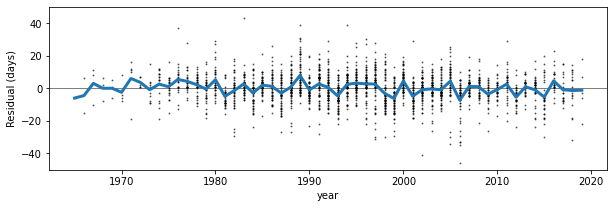

AME: 6.61, RMSE: 8.93, OOB score: 0.759


(6.610251878038003, 8.930848393459346, 0.7593231699491347)

In [58]:
summarize_result(rf,X,y, year,plot_display=True)

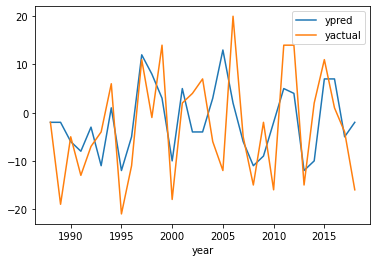

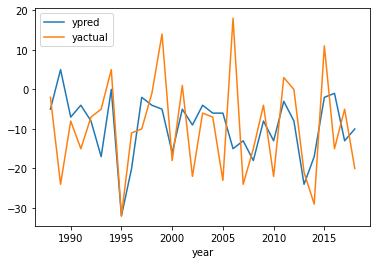

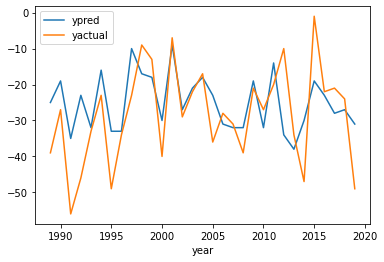

In [59]:
df_ = pd.DataFrame({'lakecode':df_data.loc[ind,'lakecode'],'year':year,'residual':np.round(rf.oob_prediction_)-y,'ypred': np.round(rf.oob_prediction_), 'yactual':y})

for lc in ['DMR1','DMR2','JJM18']:
    ind2 = df_['lakecode']==lc
    df_[ind2].set_index('year')[['ypred','yactual']].plot()

In [22]:
#df_.plot('Lake_area','ice_on_ame',marker='.',ls='none')


'_v11b'

Ice off

/Users/blagrave/.virtualenvs/icemodels/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


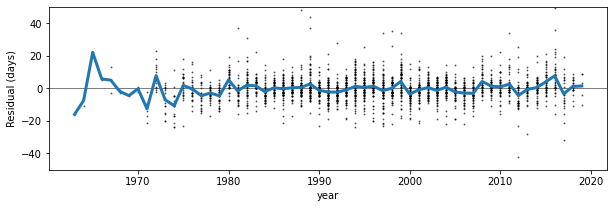

AME: 5.24, RMSE: 7.44, OOB score: 0.752


In [61]:
ice_off_features = ['Slope_100','Shore_dev','Elevation','TMINMAX_lagSON','TMINMAX_lagJJA','TMINMAX_DJF','TMINMAX_MAM']

ice_off_features = ['Elevation','Slope_100',
                    'TMINMAX_lagSON','TMINMAX_lagJJA','TMINMAX_DJF','TMINMAX_MAM']

# once slope_100 is excluded

ice_off_features = ['Elevation',
                    'Shore_dev',
                    #'Slope_100',
                    #'lon','lat',
                    'TMINMAX_lagSON','TMINMAX_lagJJA','TMINMAX_DJF','TMINMAX_MAM']
# with new weather time series
#suffix = 'B_v11'
#ice_off_features = ['Elevation',
#                    'Shore_dev',
#                    #'Slope_100',
#                    'TMINMAX_lagSON','TMINMAX_lagJJA','TMINMAX_DJF','TMINMAX_MAM',
#                   'SNOW_DJF','PRCP_MAM']



df_data = df_iceoff_limited.copy()

X = df_data.loc[:,ice_off_features]
y = df_data.loc[:, 'ice_off_doy']
year = df_data.loc[:,'start_year']
ind = ~y.isnull() & ~X.isnull().any(axis=1)

y = y[ind]
X = X[ind]
year = year[ind]
rf = RandomForestRegressor(random_state=31,max_depth=None,oob_score=True)

rf.fit(X,y)

summarize_result(rf,X,y, year,plot_display=True)


with open(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceoff_limited_seasonal_6params{suffix}.pickle','wb') as f:
    pickle.dump(rf,f)


X.to_csv(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceoff_limited_seasonal_6params{suffix}_input.csv',index=False)


In [62]:
df_ = pd.DataFrame({'lakecode':df_data.loc[ind,'lakecode'],'year':year,'residual':np.round(rf.oob_prediction_)-y,'ypred': np.round(rf.oob_prediction_), 'yactual':y})
df_.to_csv(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_iceoff_limited_seasonal_6params{suffix}_predictions.csv',index=False)

In [63]:
df_ = pd.DataFrame({'lakecode':df_data.loc[ind,'lakecode'],'residual':np.round(rf.oob_prediction_)-y,'ypred': np.round(rf.oob_prediction_), 'yactual':y})
df_ = pd.DataFrame({'ice_off_ame': df_.groupby('lakecode').apply(lambda x: np.abs(x.residual).mean()),
        'ice_off_rmse':df_.groupby('lakecode').apply(lambda x: np.sqrt(np.mean(x.residual**2)))})
df_ = df_.reset_index().merge(df_data.drop_duplicates('lakecode')[['lakecode','Depth_avg','Elevation','Slope_100','Lake_area','Elevation','Shore_dev']],left_on='lakecode',right_on='lakecode',validate='one_to_one')
df_['lake'] = df_.lakecode.apply(lambda x: lakecode_dict[x])
df_ = df_0.merge(df_[['lakecode','ice_off_ame','ice_off_rmse']],left_on='lakecode',right_on='lakecode')


In [64]:
df_.to_csv(f'/Users/blagrave/Projects/IcePhenologyModels/Models/rf_limited_seasonal_6AND8params{suffix}_lake_errors.csv',index=False)

In [65]:
suffix

'_v11b'

In [66]:
ice_on_features, ice_off_features

(['Lake_area',
  'Depth_avg',
  'Elevation',
  'TMINMAX_lagSON',
  'TMINMAX_lagJJA',
  'TMINMAX_DJF'],
 ['Elevation',
  'Shore_dev',
  'TMINMAX_lagSON',
  'TMINMAX_lagJJA',
  'TMINMAX_DJF',
  'TMINMAX_MAM'])

### Explore partial dependence plots

In [42]:
import matplotlib.gridspec as gridspec

def plot_model_summary(rf, X, features, chsize=7, labelsize=7, width=88., labels=['(a)','(b)']):
    
    
    ncols = len(features)*2
    nrows = 2
    top_margin = 0.1
    bottom_margin = 0.7
    left_margin = 0.8
    right_margin = 0.2
    w_gap = 0.05
    h_gap = 0.5
    spec_row_ratio = 1 / 0.5
    print(spec_row_ratio)
    #print(one_column_width)
    fig_width = one_column_width # inches
    
    # width and height of partial dependence plots
    plot_width = ((fig_width - left_margin - right_margin - (w_gap)*(ncols-1))/ncols)*2+w_gap
    
    plot_height = plot_width #* spec_row_ratio
    
    col_width = (plot_width - w_gap)/2
    
    #print('plot_width',plot_width)
    avg_plot_height = plot_height * (1 + spec_row_ratio)/2.
    fig_height = bottom_margin + top_margin + plot_height + plot_height*spec_row_ratio + h_gap*(nrows-1)
    #print('fig_height',fig_height)


    
    cleaned_labels = {'Shore_len':'Shoreline length (km)',
                      'lat':f'Latitude (\N{DEGREE SIGN})',
                      'Depth_avg':'Mean depth (m)', 
                      'Rad_MAM':'Spring solar radiation (MJ m$^{-2}$ d$^{-1}$)',
                      'Lake_area': 'Lake area (km$^2$)',
                      'Elevation': 'Elevation (m)',
                      'Slope_100': 'Slope within 100 m (\N{DEGREE SIGN})',
                     'Shore_dev': 'Shoreline development',
                      'SNOW_DJF':'Winter snowfall (mm)',
                      'PRCP_MAM':'Spring precipitation (mm)',
                     'TMINMAX_lagSON' : #'Fall temperature\n
                          '$T_\mathrm{SON}$ (\N{DEGREE SIGN}C)',
                      'TMINMAX_lagJJA': #'Summer temperature\n
                          '$T_\mathrm{JJA}$ (\N{DEGREE SIGN}C)',
                      'TMINMAX_DJF': #'Winter temperature\n
                          '$T_\mathrm{DJF}$ (\N{DEGREE SIGN}C)',
                     'TMINMAX_MAM': #'Spring temperature\n'
                          '$T_\mathrm{MAM}$ (\N{DEGREE SIGN}C)'}
    cleaned_labels_min = {i:j.replace(' ','\n') for i,j in cleaned_labels.items() if ('Slope' not in i) }
    cleaned_labels_min['Slope_100'] = 'Slope\nwithin\n100 m (\N{DEGREE SIGN})'
    
    #fig = plt.figure(figsize=(width/25.4, 88./25.4*0.85))
    fig = plt.figure(figsize = (fig_width, fig_height))
    
    spec = gridspec.GridSpec(ncols=ncols,nrows=nrows, 
                             figure=fig, height_ratios=[spec_row_ratio,1.0])
    axes = []
    f_ax1 = fig.add_subplot(spec[0,1:ncols])
    f_ax1.set_ylabel('',fontsize=labelsize,labelpad=4)
    f_ax1.set_xlabel('Feature importance',fontsize=labelsize)

    
    axes.append(f_ax1)
    
    for i in range(len(features)):
        if i == 0:
            axes.append(fig.add_subplot(spec[1,i:i+2]))
        else:
            axes.append(fig.add_subplot(spec[1,i*2:i*2+2],sharey=axes[1]))
            axes[i+1].tick_params(axis='y',labelleft=False)
        axes[i+1].tick_params(axis='both',labelsize=chsize)
    
    ax = axes[0]
    ax.tick_params(axis='both',labelsize=chsize)
    
    feature_importances = pd.Series(rf.feature_importances_, index=X.rename(cleaned_labels,axis=1).columns).sort_values(ascending=True)
    
    display(feature_importances.sort_values(ascending=False))
    ax.barh(feature_importances.index, feature_importances.values,facecolor='0.8',lw =0.5, height=0.7,edgecolor='k')
    
    #ax.yaxis.labelpad = 25
    
    pdp_display = PartialDependenceDisplay.from_estimator(rf,X,features=features,
                                                          line_kw = dict(color='k'),
                                            
                                                          #contour_kw = dict(norm = norm), #levels=levels), 
                                            ax=axes[1:])
    for ax in axes[1:]:
        if ax.get_xlabel() in ['Lake_area','Depth_avg']:
            #ax.axvline(9)
            ax.set_xscale('log')
    for ax in pdp_display.axes_:
        xlabel = ax.get_xlabel()
        ax.set_xlabel(cleaned_labels_min[xlabel],fontsize=labelsize)
        ax.set_ylabel(ax.get_ylabel(),fontsize=labelsize-2)
    for ax in axes[2:]:
        ax.set_ylabel('')
        
    #axes[0].text(-0.69 ,0.95,labels[0],fontsize=abcd_size,weight='bold',transform=axes[0].transAxes)
    #axes[1].text(-1.1,1.2,labels[1],fontsize=abcd_size,weight='bold',transform=axes[1].transAxes)
    axes[0].text(0.02,0.98,labels[0],ha='left',va='top',
        transform=fig.transFigure,weight='bold',fontsize=abcd_size)
    axes[0].text(0.02,0.47,labels[1],ha='left',va='top',
        transform=fig.transFigure,weight='bold',fontsize=abcd_size)

    
    fig.subplots_adjust(hspace=h_gap/avg_plot_height,
                        wspace=w_gap/col_width,
                        bottom=bottom_margin/fig_height,
                        left=left_margin/fig_width,
                        right=1-right_margin/fig_width,
                        top=1-top_margin/fig_height)
    return fig
    

/Users/blagrave/.virtualenvs/icemodels/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


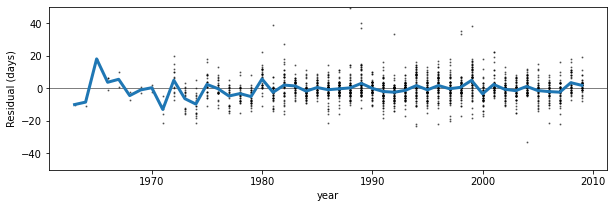

AME: 4.75, RMSE: 6.71, OOB score: 0.778
2.0


$T_\mathrm{MAM}$ (°C)                            0.541576
$T_\mathrm{DJF}$ (°C)                            0.132020
Latitude (°)                                     0.086496
Winter snowfall (mm)                             0.044029
Spring solar radiation (MJ m$^{-2}$ d$^{-1}$)    0.042277
$T_\mathrm{JJA}$ (°C)                            0.032177
$T_\mathrm{SON}$ (°C)                            0.029244
Spring precipitation (mm)                        0.028040
lon                                              0.026621
Elevation (m)                                    0.019451
Shoreline development                            0.018068
dtype: float64

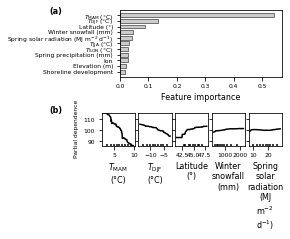

In [50]:
from sklearn.inspection import PartialDependenceDisplay


labelsize = 8
chsize = 6
abcd_size = 8


one_column_width = 3.5 # inches (this is from author guidelines)


ice_off_features = ['Elevation',
                    'Shore_dev','lon','lat',
                    #'Slope_100',
                    'TMINMAX_lagSON','TMINMAX_lagJJA','TMINMAX_DJF','TMINMAX_MAM',
                   'SNOW_DJF','PRCP_MAM', 'Rad_MAM']

columns = ['TMINMAX_MAM','TMINMAX_DJF','lat','SNOW_DJF','Rad_MAM']

df_data = df_iceoff_limited.copy()

X = df_data.loc[:,ice_off_features]
y = df_data.loc[:, 'ice_off_doy']
year = df_data.loc[:,'start_year']
ind = ~y.isnull() & ~X.isnull().any(axis=1)

y = y[ind]
X = X[ind]
year = year[ind]
rf = RandomForestRegressor(random_state=31,max_depth=None,oob_score=True)

rf.fit(X,y)

summarize_result(rf,X,y, year,plot_display=True)

fig = plot_model_summary(rf, X, columns,labelsize=labelsize,chsize=chsize)



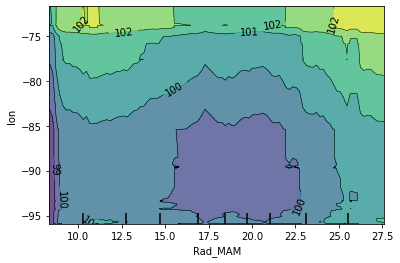

In [57]:
pdp_display = PartialDependenceDisplay.from_estimator(rf,X,features=[['Rad_MAM','lon']],
                                                          line_kw = dict(color='k'),
                                            
                                                          #contour_kw = dict(norm = norm), #levels=levels), 
                                            )

<AxesSubplot:xlabel='lat'>

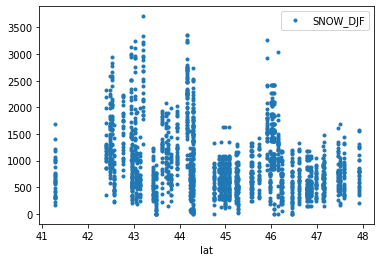

In [56]:
X.plot('lat','SNOW_DJF',marker='.',ls = 'none')